This project uses deep neural network(DNN)to predict hand-written digit graphs.  
![](https://ai-studio-static-online.cdn.bcebos.com/ba26eac845334208851e72c7a2dfef5e1eec566894ba430aba7492e72c49cacd)

 The flow chart shown as follows:

![](https://raw.githubusercontent.com/ffflora/mnist-project/master/flow-chart.PNG)

Packages:

numpy  
PIL------------> Python Image Library  
matplotlib  
os  
paddle --------> Neural network model

In [1]:

import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from PIL import Image
import matplotlib.pyplot as plt
import os

# **Step1：Data Preperation**

(1)Dataset:  

MNIST contains 60000 in training set and 10000 in test set. 
It has graphs and labels, graphs are in 28*28 pixels, labels are in 1-9.

![](https://ai-studio-static-online.cdn.bcebos.com/fc73217ae57f451a89badc801a903bb742e42eabd9434ecc8089efe19a66c076)

(2)train_reader and test_reader

paddle.dataset.mnist.train()and test()used to get the training set and test set.

paddle.reader.shuffle()used to buffer BUF_SIZE and shuffle it.

paddle.batch()each BATCH_SIZE makes a batch

（3）print and see how the data look like.  The data from PaddlePaddle's API has already been standarization and normalization.

[神经网络训练中，傻傻分不清Epoch、Batch Size和迭代](https://www.jiqizhixin.com/articles/2017-09-25-3)

In [2]:
!mkdir -p /home/aistudio/.cache/paddle/dataset/mnist/
!cp -r /home/aistudio/data/data65/*  /home/aistudio/.cache/paddle/dataset/mnist/
!ls /home/aistudio/.cache/paddle/dataset/mnist/

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [3]:
BUF_SIZE=512
BATCH_SIZE=128
# data provider, used to get data randomly from the buffer（缓存）. 

train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.train(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)

test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.mnist.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)
#用于打印，查看mnist数据
train_data=paddle.dataset.mnist.train();
sampledata=next(train_data())
print(sampledata)


(array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1. 

# **Step2. Setup Newtork**

This is a three layer multiple layer perceptron; two hidden layer which the sizes are 100, and the size of the output layer is about 10, since the label we have on hand is from 0-9. The activation function is Softmas, thus the output layer is also considered as a classifier. 
Therefore the structure of the network is: input layer ->> hidden layer ->> hidden layer ->> output layer.    
[CNN 入门讲解：什么是全连接层（Fully Connected Layer）?](https://zhuanlan.zhihu.com/p/33841176)  
![](https://ai-studio-static-online.cdn.bcebos.com/cb69f928778c4299b75814179607a89eea770bdc409d4e08a87e2975cb96b19b)

In [4]:
 
def multilayer_perceptron(input): 
    # The first fully connected layer, with the activation function ReLU 
    hidden1 = fluid.layers.fc(input=input, size=100, act='relu') 
    # The second fully connected layer, with the activation function ReLU 
    hidden2 = fluid.layers.fc(input=hidden1, size=100, act='relu') 
    # fully connected layer with Softmax as the activation function, the output must be 10  
    prediction = fluid.layers.fc(input=hidden2, size=10, act='softmax') 
    return prediction 

（2）Define the data layer  

The input data type is gray images; the size of the image is 28 * 28, so the input shape is [1,28,28]. if the input type is 32 * 32 colored image, the the input shape is [3,32,32]. Because the RGB of gray image only has one tunnel, but the color image has three tunnel.

In [5]:
# input 1*28*28
image = fluid.layers.data(name='image', shape=[1, 28, 28], dtype='float32')  
label = fluid.layers.data(name='label', shape=[1], dtype='int64')          #label of images 

（3）classifer

In [6]:
predict = multilayer_perceptron(image)

（4）Define the loss function and accuracy  

Cross Entropy Error Function is very common in classification tasks.

When a lost function is defined , we need to get the average cost as well. The training function must return a average cost as its first return value； since it is needed in the Backpropagation(反向传播算法) in the later code.

At the same time we could define a accuracy function, to provide the accuracy in the training process. 

In [17]:
# use Cross Entropy Error Function to describe the difference of label and the prediction. 
cost = fluid.layers.cross_entropy(input=predict, label=label)  
avg_cost = fluid.layers.mean(cost)
# calculate the classifier accuracy
acc = fluid.layers.accuracy(input=predict, label=label)

（5）define a optimizer function

In this case I used Adam mothod to do the optimization, and assign the learning rate is 0.01.

In [16]:
test_program = fluid.default_main_program().clone(for_test=True)
#Use AdamOptimizer
optimizer = fluid.optimizer.AdamOptimizer(learning_rate=0.001)  
opts = optimizer.minimize(avg_cost)

After the above config we have the following two fluid.Programs：fluid.default_startup_program() and fluid.default_main_program().

After the initialization all params would be read by fluid.default_startup_program()

fluid.default_main_program()used to get the default or global main program. This main program used to train and test our model.  
All the layers function in fluid.layers could add operator and variables to default_main_program. default_main_program is the API of the fluid. When program is not loaded, Executor.run() would run the default_main_program by default.

# **Step3. model training  and Step4. model evaluation **
（1）create the train Executor

First define the operation place, fluid.CPUPlace()and fluid.CUDAPlace(0) represent the CPU and GPU correspondingly.

Executor: use run() to execute the program。

In [15]:
# Define weather using CPU or GPU; when using CPU,use_cuda = False,when using GPU use_cuda = True
use_cuda = False
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

（2） two kinds of data, image value and label

DaraFeeder transfer the data from data reader to a special data structure, and feed them to the Executer.

In [12]:
feeder = fluid.DataFeeder(place=place, feed_list=[image, label])

(3)show the model curve

In [14]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

（4）train and save model  

training processing needs a training program and some necessary params, and build a function that receives the testing error.  
The necessary params including executor,program,reader,feeder,fetch_list.

**executor** 

**program** program which executer executes，if this params doesn't pass in, then use defalut_main_program() by default.

**reader** the data that read in 

**feeder** represents the variables that was inputed 

**fetch_list** represents the variabls that users want 

In [18]:
EPOCH_NUM=2
model_save_dir = "/home/aistudio/work/hand.inference.model"
for pass_id in range(EPOCH_NUM):
    # train 
    for batch_id, data in enumerate(train_reader()):                         #traverse train_reader
        train_cost, train_acc = exe.run(program=fluid.default_main_program(),#run main program 
                                        feed=feeder.feed(data),              #feed the data into 
                                        fetch_list=[avg_cost, acc])          #fetch error and accuracy  
        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        # print info and error and Accuracy each 200 batch 
        if batch_id % 200 == 0:
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' %
                  (pass_id, batch_id, train_cost[0], train_acc[0]))

    # train the model 
    test_accs = []
    test_costs = []
    # train on each testing round 
    for batch_id, data in enumerate(test_reader()):                         #traverse test_reader
        test_cost, test_acc = exe.run(program=test_program, # execute the training program 
                                      feed=feeder.feed(data),               #feed in the data 
                                      fetch_list=[avg_cost, acc])           #fetch error and Accuracy
        test_accs.append(test_acc[0])                                       #Accuracy on each batch
        test_costs.append(test_cost[0])                                     #cost on each batch 
        
       
    # avg cost on each test 
    test_cost = (sum(test_costs) / len(test_costs))                         # avg error rate  on each round 
    test_acc = (sum(test_accs) / len(test_accs))                            # avg Accuracy on each round 
    print('Test:%d, Cost:%0.5f, Accuracy:%0.5f' % (pass_id, test_cost, test_acc))
    
    #save model 

if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,   
                                  ['image'],    #inference need the data to feed
                                  [predict],    #save the results of the Variables by the inference  
                                  exe)             #executor saves the inference model

print('训练模型保存完成！')
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")

EnforceNotMet: Invoke operator adam error.
Python Callstacks: 
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/framework.py", line 1748, in append_op
    attrs=kwargs.get("attrs", None))
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/optimizer.py", line 1381, in _append_optimize_op
    stop_gradient=True)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/optimizer.py", line 386, in _create_optimization_pass
    param_and_grad)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/optimizer.py", line 531, in apply_gradients
    optimize_ops = self._create_optimization_pass(params_grads)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/optimizer.py", line 561, in apply_optimize
    optimize_ops = self.apply_gradients(params_grads)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/optimizer.py", line 600, in minimize
    loss, startup_program=startup_program, params_grads=params_grads)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/dygraph/base.py", line 88, in __impl__
    return func(*args, **kwargs)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/paddle/fluid/wrapped_decorator.py", line 25, in __impl__
    return wrapped_func(*args, **kwargs)
  File "<decorator-gen-144>", line 2, in minimize
  File "<ipython-input-16-71241d9b3f98>", line 4, in <module>
    opts = optimizer.minimize(avg_cost)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/asyncio/base_events.py", line 1425, in _run_once
    handle._run()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
C++ Callstacks: 
Enforce failed. Expected framework::product(lr_dims) == 1, but received framework::product(lr_dims):0 != 1:1.
Learning rate should have 1 dimension at [/paddle/paddle/fluid/operators/optimizers/adam_op.cc:47]
PaddlePaddle Call Stacks: 
0       0x7f536bbc5b28p void paddle::platform::EnforceNotMet::Init<std::string>(std::string, char const*, int) + 360
1       0x7f536bbc5e77p paddle::platform::EnforceNotMet::EnforceNotMet(std::string const&, char const*, int) + 87
2       0x7f536c68b95cp paddle::operators::AdamOp::InferShape(paddle::framework::InferShapeContext*) const + 4220
3       0x7f536cf07d20p paddle::framework::OperatorWithKernel::RunImpl(paddle::framework::Scope const&, boost::variant<paddle::platform::CUDAPlace, paddle::platform::CPUPlace, paddle::platform::CUDAPinnedPlace, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_> const&, paddle::framework::RuntimeContext*) const + 304
4       0x7f536cf084d1p paddle::framework::OperatorWithKernel::RunImpl(paddle::framework::Scope const&, boost::variant<paddle::platform::CUDAPlace, paddle::platform::CPUPlace, paddle::platform::CUDAPinnedPlace, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_> const&) const + 529
5       0x7f536cf0637bp paddle::framework::OperatorBase::Run(paddle::framework::Scope const&, boost::variant<paddle::platform::CUDAPlace, paddle::platform::CPUPlace, paddle::platform::CUDAPinnedPlace, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_, boost::detail::variant::void_> const&) + 267
6       0x7f536bd4442ep paddle::framework::Executor::RunPreparedContext(paddle::framework::ExecutorPrepareContext*, paddle::framework::Scope*, bool, bool, bool) + 206
7       0x7f536bd474afp paddle::framework::Executor::Run(paddle::framework::ProgramDesc const&, paddle::framework::Scope*, int, bool, bool, std::vector<std::string, std::allocator<std::string> > const&, bool) + 143
8       0x7f536bbb7e5dp
9       0x7f536bbf4956p
10      0x7f53af487199p PyCFunction_Call + 233
11      0x7f53af5223f9p PyEval_EvalFrameEx + 33545
12      0x7f53af5244b6p
13      0x7f53af5215b5p PyEval_EvalFrameEx + 29893
14      0x7f53af5244b6p
15      0x7f53af5215b5p PyEval_EvalFrameEx + 29893
16      0x7f53af5244b6p
17      0x7f53af5245a8p PyEval_EvalCodeEx + 72
18      0x7f53af5245ebp PyEval_EvalCode + 59
19      0x7f53af517c5dp
20      0x7f53af487179p PyCFunction_Call + 201
21      0x7f53af521dbep PyEval_EvalFrameEx + 31950
22      0x7f53af45b410p _PyGen_Send + 128
23      0x7f53af520953p PyEval_EvalFrameEx + 26723
24      0x7f53af45b410p _PyGen_Send + 128
25      0x7f53af520953p PyEval_EvalFrameEx + 26723
26      0x7f53af45b410p _PyGen_Send + 128
27      0x7f53af521d60p PyEval_EvalFrameEx + 31856
28      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
29      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
30      0x7f53af5244b6p
31      0x7f53af5245a8p PyEval_EvalCodeEx + 72
32      0x7f53af463c33p
33      0x7f53af43233ap PyObject_Call + 106
34      0x7f53af51c6eep PyEval_EvalFrameEx + 9726
35      0x7f53af5244b6p
36      0x7f53af5215b5p PyEval_EvalFrameEx + 29893
37      0x7f53af45a6bap
38      0x7f53af515af6p
39      0x7f53af487179p PyCFunction_Call + 201
40      0x7f53af521dbep PyEval_EvalFrameEx + 31950
41      0x7f53af5244b6p
42      0x7f53af5215b5p PyEval_EvalFrameEx + 29893
43      0x7f53af45a6bap
44      0x7f53af515af6p
45      0x7f53af487179p PyCFunction_Call + 201
46      0x7f53af521dbep PyEval_EvalFrameEx + 31950
47      0x7f53af5244b6p
48      0x7f53af5215b5p PyEval_EvalFrameEx + 29893
49      0x7f53af45a6bap
50      0x7f53af515af6p
51      0x7f53af487179p PyCFunction_Call + 201
52      0x7f53af521dbep PyEval_EvalFrameEx + 31950
53      0x7f53af5244b6p
54      0x7f53af5245a8p PyEval_EvalCodeEx + 72
55      0x7f53af463b56p
56      0x7f53af43233ap PyObject_Call + 106
57      0x7f53af51c6eep PyEval_EvalFrameEx + 9726
58      0x7f53af45b410p _PyGen_Send + 128
59      0x7f53af521d60p PyEval_EvalFrameEx + 31856
60      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
61      0x7f53af5244b6p
62      0x7f53af5245a8p PyEval_EvalCodeEx + 72
63      0x7f53af463c33p
64      0x7f53af43233ap PyObject_Call + 106
65      0x7f53af51c6eep PyEval_EvalFrameEx + 9726
66      0x7f53af5244b6p
67      0x7f53af5245a8p PyEval_EvalCodeEx + 72
68      0x7f53af463b56p
69      0x7f53af43233ap PyObject_Call + 106
70      0x7f53af597ccap
71      0x7f53af43233ap PyObject_Call + 106
72      0x7f53af51e4c5p PyEval_EvalFrameEx + 17365
73      0x7f53af5244b6p
74      0x7f53af5245a8p PyEval_EvalCodeEx + 72
75      0x7f53af463b56p
76      0x7f53af43233ap PyObject_Call + 106
77      0x7f53af51c6eep PyEval_EvalFrameEx + 9726
78      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
79      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
80      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
81      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
82      0x7f53af5221d0p PyEval_EvalFrameEx + 32992
83      0x7f53af5244b6p
84      0x7f53af5215b5p PyEval_EvalFrameEx + 29893
85      0x7f53af5244b6p
86      0x7f53af5245a8p PyEval_EvalCodeEx + 72
87      0x7f53af5245ebp PyEval_EvalCode + 59
88      0x7f53af517c5dp
89      0x7f53af487179p PyCFunction_Call + 201
90      0x7f53af521dbep PyEval_EvalFrameEx + 31950
91      0x7f53af5244b6p
92      0x7f53af5215b5p PyEval_EvalFrameEx + 29893
93      0x7f53af5244b6p
94      0x7f53af5245a8p PyEval_EvalCodeEx + 72
95      0x7f53af463b56p
96      0x7f53af43233ap PyObject_Call + 106
97      0x7f53af570ba1p
98      0x7f53af5714a5p Py_Main + 1493
99            0x400b54p main + 356


# **Step5. model prediction**

（1）image propreccessing 

Before the prediction, need to do the image preprocessing.
First need to do the grayscale to the images, and compress all the images to the size of 28 * 28, and transfer the images to 1d vectot, and do the standarization to the dataset

In [19]:
def load_image(file):
    im = Image.open(file).convert('L')                        #grayscale the RGB to gray images, L represents gray images, pixels are in the range of 0-255
    im = im.resize((28, 28), Image.ANTIALIAS)                 #resize image with high-quality in 28*28
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)#reshape the array, make it a numby array 
    # print(im)
    im = im / 255.0 * 2.0 - 1.0                               # standarizate the data into the range of [-1,1]
    return im


（2）display the image with matplotlib

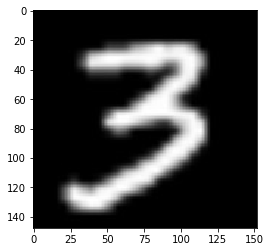

In [20]:
infer_path='/home/aistudio/data/data2304/infer_3.png'
img = Image.open(infer_path)
plt.imshow(img)   
plt.show()        

# (3)Create the Executer for prediction

In [21]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope()

(4)start prediction 

use fluid.io.load_inference_model，predictor reads the pre_trained models params_dirname, and 来对从未遇见过的数据进行预测。

In [16]:
# load data and start predicting
with fluid.scope_guard(inference_scope):
    #获取训练好的模型
    #load (inference model)
    [inference_program,                                            
     feed_target_names,                                            #str list，which contains all the variables that inference model needs 
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,#fetch_targets：variable list, we could get the inference results. 
                                                    infer_exe)     #infer_exe: run the inference model's executor
    img = load_image(infer_path)

    results = infer_exe.run(program=inference_program,               # run the inference function
                   feed={feed_target_names[0]: img},           #feed the img that needed to be predicted 
                   fetch_list=fetch_targets)                   # get the inference results 
    # 获取概率最大的label
    lab = np.argsort(results)                                  #sort the results from small to large
    #print(lab)
    print("该图片的预测结果的label为: %d" % lab[0][0][-1])     

该图片的预测结果的label为: 3
